# CNSGA Importer for NSGA2
This notebook demonstrates the use of the function `nsga2_from_cnsga_output_path` which constructs an `NSGA2Generator` object from the population file outputs in `CNSGAGenerator`. To do this, a optimization problem is solved using the `CNSGAGenerator` with the data saved to a temporary directory. The outputs are then loaded by the function being demonstrated and a single generation run with `NSGA2Generator`. The outputs of both generators are plotted to show how the created generator picked up where the old one left off.

In [1]:
from paretobench.plotting import population_obj_scatter
from paretobench import Problem, Population
from xopt import Xopt, Evaluator
from xopt.generators.ga.cnsga import CNSGAGenerator
import logging
import tempfile

from electronsandstuff.paretobench.xopt import XoptProblemWrapper
from electronsandstuff.xopt import nsga2_from_cnsga_output_path

In [2]:
# Setup logging for xopt converter
logger = logging.getLogger("electronsandstuff.paretobench.xopt")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

2025-04-05 18:43:21,479 - INFO - Evaluating 64 generations in xopt:
2025-04-05 18:43:22,180 - INFO -   Complete!


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$f_1$', ylabel='$f_2$'>)

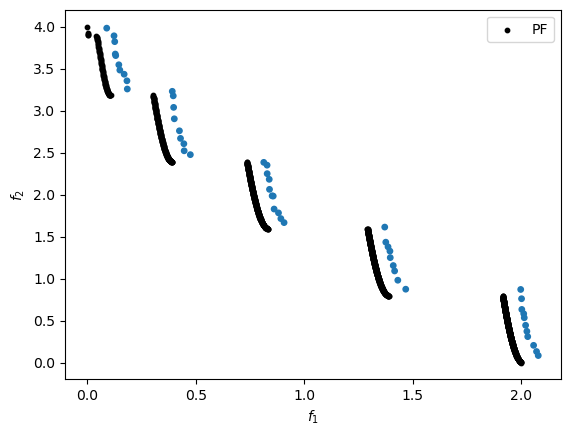

In [3]:
# Optimizer settings
population_size = 50
n_generations = 64

# Our test problem
prob = XoptProblemWrapper(Problem.from_line_fmt("WFG2 (n=16, k=2, m=2)"))

# Get a path for the data
output_path = tempfile.mkdtemp()

# Setup CNSGA generator in xopt to solve it
ev = Evaluator(function=prob, vectorized=True, max_workers=population_size)
X = Xopt(
    generator=CNSGAGenerator(
        vocs=prob.vocs, population_size=population_size, output_path=output_path
    ),
    evaluator=ev,
    vocs=prob.vocs,
)
X.strict = False

# Run the optimizer
logger.info(f"Evaluating {n_generations} generations in xopt:")
for gen in range(n_generations):
    X.step()
logger.info("  Complete!")

# Convert to a population and plot
pop = Population(
    x=X.generator.vocs.variable_data(X.generator.population).to_numpy(),
    f=X.generator.vocs.objective_data(X.generator.population).to_numpy(),
    g=None
    if len(X.generator.vocs.constant_names) == 0
    else X.generator.vocs.constraint_data(X.generator.population).to_numpy(),
)
population_obj_scatter(pop, problem=prob.prob.to_line_fmt())

2025-04-05 18:43:22,851 - INFO - Evaluating one more generation with NSGA2 in xopt:
2025-04-05 18:43:22,865 - INFO -   Complete!


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$f_1$', ylabel='$f_2$'>)

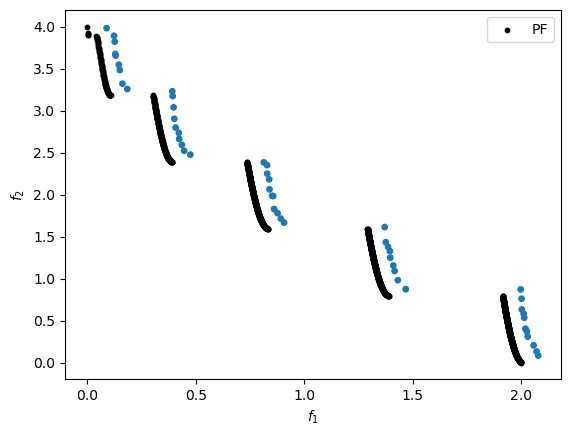

In [4]:
# Create the generator from the existing CNSGA populations and put into xopt object
X2 = Xopt(
    generator=nsga2_from_cnsga_output_path(output_path, vocs=prob.vocs),
    evaluator=ev,
    vocs=prob.vocs,
)
X2.strict = False

# Run the optimizer
logger.info("Evaluating one more generation with NSGA2 in xopt:")
X2.step()
logger.info("  Complete!")

# Construct population and plot
pop = Population(
    x=X2.generator.vocs.variable_data(X2.generator.pop).to_numpy(),
    f=X2.generator.vocs.objective_data(X2.generator.pop).to_numpy(),
    g=None
    if len(X2.generator.vocs.constant_names) == 0
    else X2.generator.vocs.constraint_data(X2.generator.pop).to_numpy(),
    fevals=X2.generator.fevals,
)
population_obj_scatter(pop, problem=prob.prob.to_line_fmt())